In [1]:
import numpy as np

class SailBoatEnvironment:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.wind_direction = np.random.uniform(0, 2*np.pi)
        self.boat_position = np.array([0, 0])
        self.target_position = np.array([np.random.uniform(-10, 10), np.random.uniform(-10, 10)])
        self.sail_configs = np.linspace(0, 1, 16) #16 allowed positions of the sail
        self.rudder_configs = np.linspace(-np.pi/4, np.pi/4, 16) #The values of -np.pi/4 and np.pi/4 are chosen to represent the limits of the rudder configuration. These values correspond to the maximum angles 
                                                                #that the rudder can be turned left and right from the center position.The choice of np.pi/4 as the maximum #
                                                                # angle is somewhat arbitrary, but it is a common choice in sailing and boating applications.
        
        
        self.q_table = np.zeros((16, 16, 3))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def reset(self):
        self.wind_direction = np.random.uniform(0, 2*np.pi)
        self.boat_position = np.array([0, 0])
        self.target_position = np.array([np.random.uniform(-10, 10), np.random.uniform(-10, 10)])
        return self.get_state()

    def get_state(self):
        relative_wind_direction = self.wind_direction - np.arctan2(*self.boat_position[::-1])
        distance_to_target = np.linalg.norm(self.boat_position - self.target_position)
        return relative_wind_direction, distance_to_target

    def step(self, action):
        sail_config, rudder_config = action
        sail_force = sail_config * np.sin(self.wind_direction - np.arctan2(*self.boat_position[::-1]))
        rudder_force = rudder_config * np.cos(self.wind_direction - np.arctan2(*self.boat_position[::-1]))
        boat_velocity = np.array([np.cos(self.wind_direction), np.sin(self.wind_direction)]) * sail_force + np.array([-np.sin(self.wind_direction), np.cos(self.wind_direction)]) * rudder_force
        self.boat_position = (self.boat_position + boat_velocity).astype(np.float64)
        state = self.get_state()
        done = False
        reward = -1

        if np.any(np.abs(self.boat_position) > 20):
            done = True
            reward = -10

        distance_to_target = state[1]
        if distance_to_target < 0.5:
            done = True
            reward = 150

        # Q-learning update
        sail_idx = np.argmin(np.abs(self.sail_configs - sail_config))
        rudder_idx = np.argmin(np.abs(self.rudder_configs - rudder_config))
        q_current = self.q_table[sail_idx, rudder_idx, 0]
        q_next = np.max(self.q_table[sail_idx, rudder_idx, :])
        self.q_table[sail_idx, rudder_idx, 0] += self.alpha * (reward + self.gamma * q_next - q_current)

        return state, reward, done


In [2]:
env=SailBoatEnvironment()

In [3]:
#randomly generated
state = env.reset()
print(state)

(0.7740217212011546, 5.083252660807365)


In [4]:
#the same as before without the print statement
#both give the relative wind direction and the euclidean distance between the current position of the boat and the randomly generated porition of the target
env.reset()

(4.326203375392888, 9.070075369397387)

In [5]:
env.boat_position


array([0, 0])

In [6]:
#with print statement
target_position = env.target_position
print(target_position)

[-8.596901    2.89129044]


In [12]:
env = SailBoatEnvironment()
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        # Choose action using epsilon-greedy policy
        action = [np.random.choice(env.sail_configs), np.random.choice(env.rudder_configs)]
        if np.random.uniform() < env.epsilon:
            pass
        else:
            sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
            action = [env.sail_configs[sail_idx], env.rudder_configs[rudder_idx]]
        
        # Take action
        next_state, reward, done = env.step(action)
        
        # Update Q-table
        sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
        q_current = env.q_table[sail_idx, rudder_idx, 0]
        q_next = np.max(env.q_table[sail_idx, rudder_idx, :])
        env.q_table[sail_idx, rudder_idx, 0] += env.alpha * (reward + env.gamma * q_next - q_current)
        
        state = next_state
        total_reward += reward
    
    print(f"Episode {episode+1}, Total reward: {total_reward}, New Position: ({state[0]:.2f}, {state[1]:.2f}), Target Position: ({env.target_position[0]:.2f}, {env.target_position[1]:.2f})")


Episode 1, Total reward: -99, New Position: (3.57, 29.73), Target Position: (-9.30, 8.86)
Episode 2, Total reward: -297, New Position: (6.92, 24.26), Target Position: (-9.03, -7.03)
Episode 3, Total reward: -123, New Position: (6.64, 19.54), Target Position: (7.86, 5.39)
Episode 4, Total reward: -148, New Position: (0.39, 16.97), Target Position: (-5.11, 3.41)
Episode 5, Total reward: -292, New Position: (6.31, 24.91), Target Position: (-3.50, -6.29)
Episode 6, Total reward: -159, New Position: (0.34, 25.76), Target Position: (9.53, -3.69)
Episode 7, Total reward: -296, New Position: (3.69, 15.02), Target Position: (2.39, 8.93)
Episode 8, Total reward: -110, New Position: (3.60, 33.14), Target Position: (0.10, -8.41)
Episode 9, Total reward: -291, New Position: (3.36, 32.92), Target Position: (-8.56, -3.65)
Episode 10, Total reward: -463, New Position: (6.39, 12.87), Target Position: (-6.59, -9.13)
Episode 11, Total reward: -192, New Position: (3.36, 18.86), Target Position: (1.38, 1.3

Episode 1, Total reward: -292, New Position: (4.04, 25.36), Target Position: (-4.09, 2.77)
Episode 2, Total reward: -70, New Position: (3.70, 15.69), Target Position: (-2.72, -8.92)
Episode 3, Total reward: -149, New Position: (0.52, 16.45), Target Position: (-4.37, 8.40)
Episode 4, Total reward: -93, New Position: (3.68, 21.78), Target Position: (5.18, 1.18)
Episode 5, Total reward: -126, New Position: (7.01, 20.30), Target Position: (-7.64, -7.93)
Episode 6, Total reward: -70, New Position: (0.45, 27.30), Target Position: (-1.90, 3.08)
Episode 7, Total reward: -61, New Position: (3.88, 30.47), Target Position: (-9.95, 6.35)
Episode 8, Total reward: -57, New Position: (3.87, 29.04), Target Position: (-3.52, -2.79)
Episode 9, Total reward: -49, New Position: (3.83, 30.05), Target Position: (5.34, -9.80)
Episode 10, Total reward: -193, New Position: (0.35, 30.53), Target Position: (1.68, -9.63)
Episode 11, Total reward: -230, New Position: (6.81, 16.48), Target Position: (-7.04, -6.62)


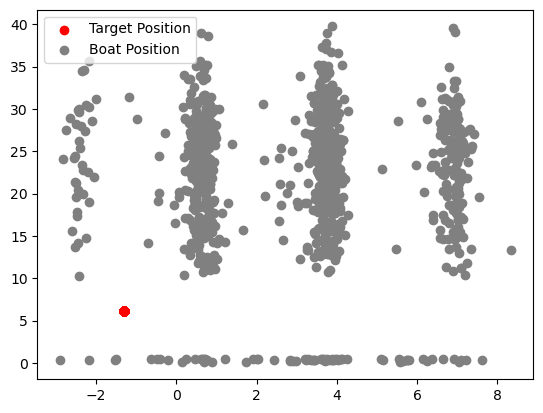

In [14]:
import matplotlib.pyplot as plt

env = SailBoatEnvironment()
num_episodes = 1000

# create empty arrays to store positions for each episode
boat_positions = np.zeros((num_episodes, 2))
target_positions = np.tile(env.target_position, (num_episodes, 1))

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        # Choose action using epsilon-greedy policy
        if np.random.uniform() < env.epsilon:
            action = [np.random.choice(env.sail_configs), np.random.choice(env.rudder_configs)]
        else:
            sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
            action = [env.sail_configs[sail_idx], env.rudder_configs[rudder_idx]]

        # Take action
        next_state, reward, done = env.step(action)

        # Update Q-table
        sail_idx, rudder_idx = np.searchsorted(env.sail_configs, action[0]), np.searchsorted(env.rudder_configs, action[1])
        q_current = env.q_table[sail_idx, rudder_idx, 0]
        q_next = np.max(env.q_table[sail_idx, rudder_idx, :])
        env.q_table[sail_idx, rudder_idx, 0] += env.alpha * (reward + env.gamma * q_next - q_current)

        state = next_state
        total_reward += reward
    
    # store final position in boat_positions array
    boat_positions[episode, :] = state
    
    print(f"Episode {episode+1}, Total reward: {total_reward}, New Position: ({state[0]:.2f}, {state[1]:.2f}), Target Position: ({env.target_position[0]:.2f}, {env.target_position[1]:.2f})")

# create scatter plot of boat positions and target positions
fig, ax = plt.subplots()
ax.scatter(target_positions[:, 0], target_positions[:, 1], color='red',label='Target Position')
ax.scatter(boat_positions[:, 0], boat_positions[:, 1], color='gray', label='Boat Position')
ax.legend()
plt.show()


the Q-table is a 3-dimensional numpy array with dimensions (11, 11, 3). The first two dimensions correspond to the sail and rudder configurations, respectively, and the third dimension corresponds to the Q-values for each possible action (there are 3 actions in total: sail left, sail straight, and sail right).

self.wind_direction is a random value between 0 and 2π.
self.boat_position is a NumPy array containing the initial position of the boat, which is (0, 0).
self.target_position is a NumPy array containing the position of the target, which is a random point within a rectangle centered at the origin with width and height of 20 units.
self.sail_configs is a NumPy array containing 11 equally spaced values between 0 and 1, representing the possible sail configurations.
self.rudder_configs is a NumPy array containing 11 equally spaced values between -π/4 and π/4, representing the possible rudder configurations.
self.q_table is a 3-dimensional NumPy array of zeros with shape (11, 11, 3), representing the Q-values for each possible combination of sail and rudder configurations.

sail_idx = np.argmin(np.abs(self.sail_configs - sail_config)) finds the index of the sail configuration that is closest to the desired sail configuration specified by sail_config. This is used to index into the first dimension of the Q-table.

rudder_idx = np.argmin(np.abs(self.rudder_configs - rudder_config)) finds the index of the rudder configuration that is closest to the desired rudder configuration specified by rudder_config. This is used to index into the second dimension of the Q-table.

q_current = self.q_table[sail_idx, rudder_idx, 0] retrieves the current Q-value for the current state and action (which is the "sail straight" action, corresponding to the index 0 in the third dimension).

q_next = np.max(self.q_table[sail_idx, rudder_idx, :]) computes the estimated Q-value for the next state, which is the maximum Q-value over all possible actions in the next state (i.e., the action that maximizes the Q-value). This is used to estimate the expected total reward that can be obtained from the next state.

self.q_table[sail_idx, rudder_idx, 0] += self.alpha * (reward + self.gamma * q_next - q_current) updates the Q-value for the current state and action, using the Q-learning update rule

The Q-learning update equation is used to update the Q-value for the current state and action. The Q-value for the current state and action is q_current, and q_next is the maximum Q-value for the next state. The update is performed as follows:

new_q_value = old_q_value + learning_rate * (reward + discount_factor * max_q_next - old_q_value)

where learning_rate is the step size, reward is the reward obtained from the current action, discount_factor is the discount factor for future rewards, and max_q_next is the maximum Q-value for the next state.

In the code, q_current is the current Q-value for the current state and action, and q_next is the maximum Q-value for the next state. The Q-value for the current state and action is updated using the above equation, and the new value is stored back in the Q-table.

relative_wind_direction = self.wind_direction - np.arctan2(*self.boat_position[::-1])
self.wind_direction: This is a scalar value that represents the direction of the wind, expressed in radians.
np.arctan2(*self.boat_position[::-1]): This is a function call to np.arctan2, which computes the arctangent of the ratio of two given inputs. In this case, the inputs are the components of the boat's position vector, reversed using [::-1]. The * before self.boat_position[::-1] unpacks the tuple of components into separate arguments for the np.arctan2 function. The resulting output is the angle in radians between the positive x-axis and a line connecting the boat's position to the origin.
self.wind_direction - np.arctan2(*self.boat_position[::-1]): This subtracts the angle from step 2 from the wind direction angle from step 1, resulting in the relative wind direction, which is the angle in radians between the boat's heading and the direction of the wind.
Overall, this line of code is computing the relative wind direction, which is an important parameter for calculating the sail force applied to the boat in the subsequent lines of code.